In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the datasets
consumption_df = pd.read_csv('Datathon Data/Energy Data - Consumption.csv')
emissions_df = pd.read_csv('Datathon Data/Energy Data - Emissions.csv')

# Rename columns to ensure consistency
emissions_df.rename(columns={'MSN': 'EIA_ID'}, inplace=True)
consumption_df.drop(columns=['Energy Category'], inplace=True)

# Remove rows with missing, 'Not Available', or 'Not Meaningful' values in the 'Value' column
consumption_df = consumption_df[~consumption_df['Value'].isna() &
                                (consumption_df['Value'] != 'Not Available') &
                                (consumption_df['Value'] != 'Not Meaningful') &
                                (consumption_df['Value'] != 'No Data Reported')]
emissions_df = emissions_df[~emissions_df['Value'].isna() &
                            (emissions_df['Value'] != 'Not Available') &
                            (emissions_df['Value'] != 'Not Meaningful') &
                            (emissions_df['Value'] != 'No Data Reported')]

# Handle 'N/A', empty, and NaN values in the 'Sector' column to denote 'Overall'
consumption_df['Sector'] = consumption_df['Sector'].replace({'N/A': 'Overall', '': 'Overall', np.nan: 'Overall'})
emissions_df['Sector'] = emissions_df['Sector'].replace({'N/A': 'Overall', '': 'Overall', np.nan: 'Overall'})

# Since the emissions DataFrame was adjusted to match the consumption DataFrame columns
# Ensure the column order in emissions_df matches that of consumption_df before merging
emissions_df = emissions_df[consumption_df.columns]

# reset emissions value to emission
emissions_df.rename(columns={'Value': 'Emission (Mton Co2)'}, inplace=True)
emissions_df.drop(columns=['Unit'], inplace=True)
consumption_df.rename(columns={'Value': 'Consumption'}, inplace=True)
consumption_df['Consumption'] = consumption_df['Consumption'].astype(float)
emissions_df['Emission (Mton Co2)'] = emissions_df['Emission (Mton Co2)'].astype(float)

# change units to match
consumption_df['Consumption'] = consumption_df.apply(lambda row: row['Consumption'] * 178000 if row['Unit'] == 'Billion Cubic Feet' else row['Consumption'], axis=1)
consumption_df['Consumption'] = consumption_df.apply(lambda row: row['Consumption'] / 5 if row['Unit'] == 'Thousand Short Tons' else row['Consumption'], axis=1)
consumption_df.rename(columns={'Consumption': 'Consumption (kBarrel)'}, inplace=True)
consumption_df.drop(columns=['Unit'], inplace=True)

# Merge the datasets. inner join to ensure that only matching rows are retained
final_df = pd.merge(consumption_df, emissions_df, on=['Date', 'YYYYMM', 'Energy Type', 'Energy Class', 'Sector'], how='inner')
final_df.drop(columns=['EIA_ID_y'], inplace=True)
final_df.rename(columns={'EIA_ID_x': 'EIA_ID'}, inplace=True)
final_df.drop(columns=['YYYYMM', 'Description_x', 'Description_y'], inplace=True)
final_df['Emission per Consumption'] = final_df['Emission (Mton Co2)'] / final_df['Consumption (kBarrel)']
final_df['Date'] = pd.to_datetime(final_df['Date'])
final_df.sort_values(by='Date', inplace=True)

# Save the merged dataset
final_df.to_csv('Data/emission_consumption.csv', index=False)

# Display the first few rows of the merged dataset
print(final_df.head())


        EIA_ID       Date  Consumption (kBarrel)  Column_Order_x  \
0      DFRCPUS 1973-01-01           1.706943e+03               1   
15083  PCEIZUS 1973-01-01           6.721000e+00              11   
18749  NGEIPUS 1973-01-01           3.988980e+07              11   
14472  DKEIZUS 1973-01-01           1.808870e+02              10   
13861  PAACPUS 1973-01-01           8.508201e+03               9   

               Energy Type Energy Class          Sector  Emission (Mton Co2)  \
0      Distillate Fuel Oil    Petroleum     Residential               22.796   
15083       Petroleum Coke    Petroleum  Electric Power                0.128   
18749          Natural Gas  Natural Gas  Electric Power               12.163   
14472  Distillate Fuel Oil    Petroleum  Electric Power                2.397   
13861                Total    Petroleum  Transportation              101.775   

       Column_Order_y  Emission per Consumption  
0                   3              1.335487e-02  
15083     

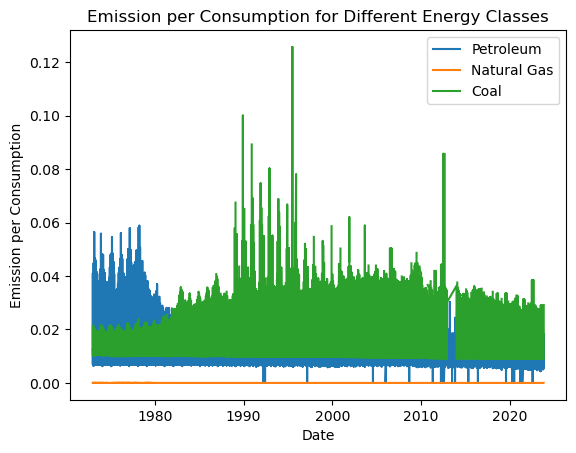

In [42]:
# plot emission per consumption for different energy classes

energy_classes = final_df['Energy Class'].unique()
for energy_class in energy_classes:
    energy_class_df = final_df[final_df['Energy Class'] == energy_class]
    plt.plot(energy_class_df['Date'], energy_class_df['Emission per Consumption'], label=energy_class)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Emission per Consumption')
plt.title('Emission per Consumption for Different Energy Classes')
plt.show()

/var/folders/2f/cvmbnp4s1r362w323xc1fx800000gn/T/ipykernel_55597/2078163055.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  total_df = total_df.groupby('Date').sum()


<Axes: xlabel='Date'>

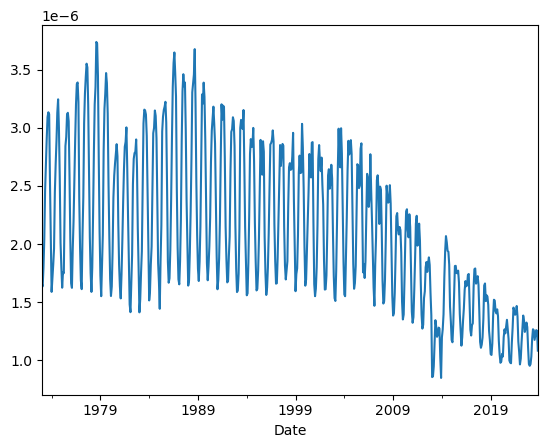

In [70]:
total_df = final_df[final_df['Energy Type'] != 'Total']
total_df = total_df.groupby('Date').sum()
total_df = total_df[['Consumption (kBarrel)', 'Emission (Mton Co2)']]
total_df['Emission/Consumption'] = total_df['Emission (Mton Co2)'] / total_df['Consumption (kBarrel)']
total_df.head()
total_df['Emission/Consumption'].plot()

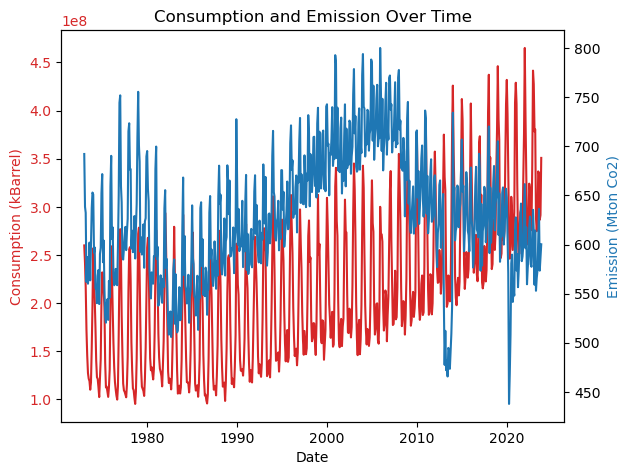

In [52]:
# plot emission and consumption on the same graph but different scales

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Consumption (kBarrel)', color=color)
ax1.plot(total_df.index, total_df['Consumption (kBarrel)'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Emission (Mton Co2)', color=color)
ax2.plot(total_df.index, total_df['Emission (Mton Co2)'], color=color)

fig.tight_layout()
plt.title('Consumption and Emission Over Time')
plt.show()

/var/folders/2f/cvmbnp4s1r362w323xc1fx800000gn/T/ipykernel_55597/1521974371.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  petroleum = petroleum[final_df['Energy Type'] == 'Total']


Text(0.5, 1.0, 'Consumption for Different Energy Classes')

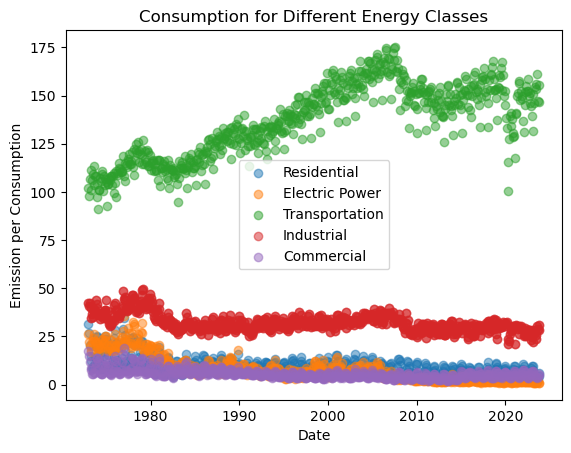

In [71]:
# graph emission and consumption for different energy classes

energy_classes = final_df['Energy Class'].unique()
petroleum = final_df[final_df['Energy Class'] == 'Petroleum']
petroleum = petroleum[final_df['Energy Type'] == 'Total']

# graph emission and consumption for different sectors

sectors = final_df['Sector'].unique()
for sector in sectors:
    sector_df = petroleum[petroleum['Sector'] == sector]
    plt.scatter(sector_df['Date'], sector_df['Emission (Mton Co2)'], label=sector, alpha = 0.5)

plt.legend()
plt.xlabel('Date')
plt.ylabel('Emission per Consumption')
plt.title('Consumption for Different Energy Classes')

In [79]:
# stationary test for consumption in petroleum sector
from statsmodels.tsa.stattools import adfuller

sectors = final_df['Sector'].unique()
for sector in sectors:
    sector_df = petroleum[petroleum['Sector'] == sector]
    result = adfuller(sector_df['Consumption (kBarrel)'])
    print(f'Stationary test for {sector}:')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
        

Stationary test for Residential:
ADF Statistic: -2.253954
p-value: 0.187249
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569
Stationary test for Electric Power:
ADF Statistic: -1.739843
p-value: 0.410710
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569
Stationary test for Transportation:
ADF Statistic: -1.380802
p-value: 0.591444
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569
Stationary test for Industrial:
ADF Statistic: -1.320447
p-value: 0.619767
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Stationary test for Commercial:
ADF Statistic: -2.187836
p-value: 0.210690
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569


/var/folders/2f/cvmbnp4s1r362w323xc1fx800000gn/T/ipykernel_55597/2550618444.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  total_emission = final_df.groupby(['Date', 'Energy Class']).sum()


<Axes: xlabel='Date'>

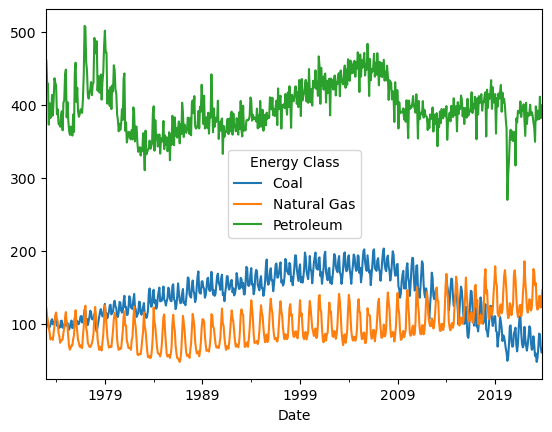

In [87]:
# total emission by energy class
total_emission = final_df.groupby(['Date', 'Energy Class']).sum()
total_emission = total_emission[['Emission (Mton Co2)']]
total_emission = total_emission.unstack()
total_emission.columns = total_emission.columns.droplevel()
total_emission.plot()

/var/folders/2f/cvmbnp4s1r362w323xc1fx800000gn/T/ipykernel_55597/603844445.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  energy_class_df = energy_class_df.groupby('Date').sum()


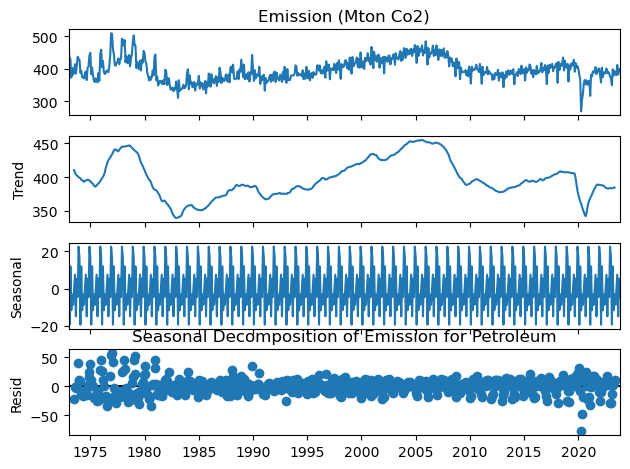

/var/folders/2f/cvmbnp4s1r362w323xc1fx800000gn/T/ipykernel_55597/603844445.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  energy_class_df = energy_class_df.groupby('Date').sum()


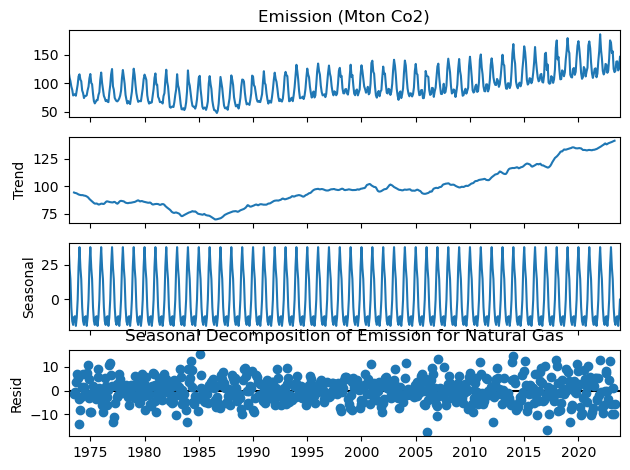

/var/folders/2f/cvmbnp4s1r362w323xc1fx800000gn/T/ipykernel_55597/603844445.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  energy_class_df = energy_class_df.groupby('Date').sum()


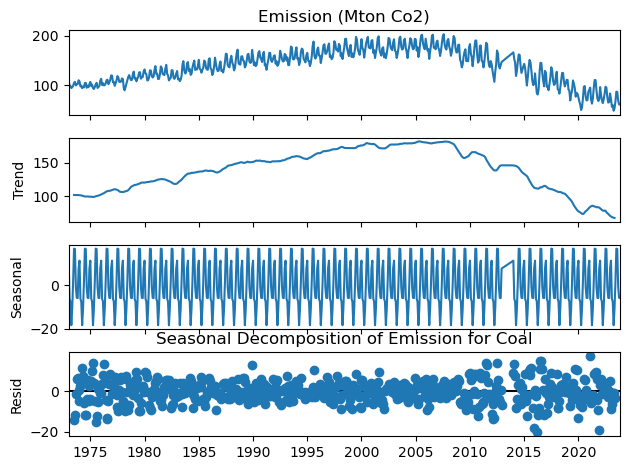

In [90]:
# seasonally decompose the emission data for different energy classes
from statsmodels.tsa.seasonal import seasonal_decompose
energy_classes = final_df['Energy Class'].unique()
for energy_class in energy_classes:
    energy_class_df = final_df[final_df['Energy Class'] == energy_class]
    energy_class_df = energy_class_df.groupby('Date').sum()
    result = seasonal_decompose(energy_class_df['Emission (Mton Co2)'], model='additive', period=12)
    result.plot()
    plt.title(f'Seasonal Decomposition of Emission for {energy_class}')
    plt.show()

/var/folders/2f/cvmbnp4s1r362w323xc1fx800000gn/T/ipykernel_55597/1524623563.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  energy_class_df = energy_class_df.groupby('Date').sum()


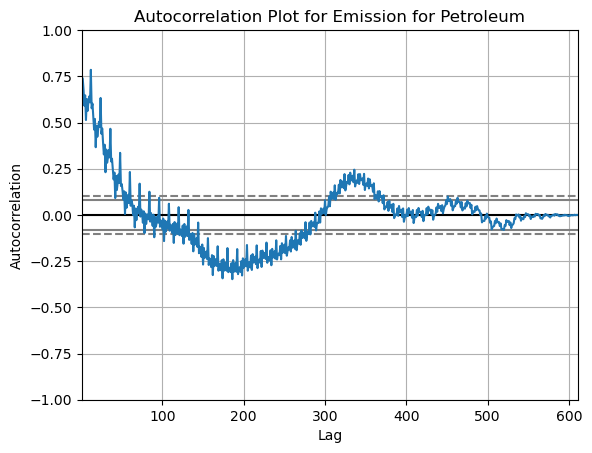

/var/folders/2f/cvmbnp4s1r362w323xc1fx800000gn/T/ipykernel_55597/1524623563.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  energy_class_df = energy_class_df.groupby('Date').sum()


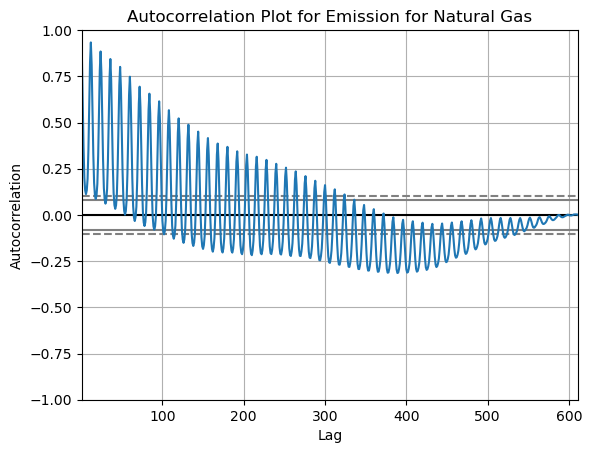

/var/folders/2f/cvmbnp4s1r362w323xc1fx800000gn/T/ipykernel_55597/1524623563.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  energy_class_df = energy_class_df.groupby('Date').sum()


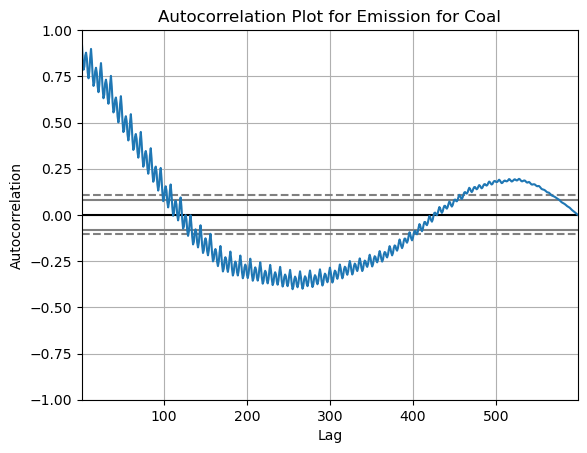

In [89]:
# autocorrelation plot for emission data
from pandas.plotting import autocorrelation_plot
energy_classes = final_df['Energy Class'].unique()
for energy_class in energy_classes:
    energy_class_df = final_df[final_df['Energy Class'] == energy_class]
    energy_class_df = energy_class_df.groupby('Date').sum()
    autocorrelation_plot(energy_class_df['Emission (Mton Co2)'])
    plt.title(f'Autocorrelation Plot for Emission for {energy_class}')
    plt.show()
    